In [101]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython import display
import sys
sys.path.append("../")
from DSP_prototype.DSP_algorithms import stft
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_model_optimization as tfmot

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


# Informacje o zbiorze danych "speech_commands"

## Etykiety
W zbiorze danych znajdują się pliki audio próbkowane z częstotliwością $f=16$kHz. Każdemu plikowi przypisana jest jedna z 12 dostępnych klas, które numerowane są w następujący sposób:

- 0 - down
- 1 - go
- 2 - left
- 3 - no
- 4 - off
- 5 - on
- 6 - right
- 7 - stop
- 8 - up
- 9 - yes
- 10 - silence
- 11 - unknown

In [3]:
sample_rate = 16000
label_strings = ["down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes", "silence", "unknown"]
selected_labels = [1, 2, 3, 6, 7, 9, 10, 11]
selected_labels_dict = {x:i for i, x in enumerate(selected_labels)}
NUM_CLASSES = len(selected_labels)
commands = [label_strings[x] for x in selected_labels]

# Select data for training

In [4]:
dataset, info = tfds.load('speech_commands', with_info=True, as_supervised=True, split="test+validation+train")
print(f"Full dataset length: {len(dataset)}")

exclude_classes = [x for x in range(12) if x not in selected_labels]
dataset = dataset.shuffle(10000, seed=2137)

I0000 00:00:1737115671.349896   23544 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6014 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 Super, pci bus id: 0000:01:00.0, compute capability: 7.5


Full dataset length: 100503


In [63]:
def split_data_and_labels(dataset, length):
    data = []
    labels = []
    i = 0
    unknown_counter = 0
    for feature, label in dataset:
        if i == length:
            break
            
        pcm = feature.numpy()
        pcm_padded = np.pad(pcm, (0, sample_rate - len(pcm)), 'constant', constant_values=0)
        pcm_padded = pcm_padded.astype(np.float32)
        pcm_padded = librosa.resample(pcm_padded, orig_sr=16e3, target_sr=8e3)
        # pcm_padded += np.random.uniform(0, 200, size=(pcm_padded.size))
        
        label = int(label.numpy())
        if label in selected_labels:
            if label == 11 and unknown_counter < 5:
                unknown_counter += 1
                
            if (label == 11 and unknown_counter == 5) or label != 11:
                data.append(pcm_padded)
                labels.append(selected_labels_dict.get(label))
                i += 1
                unknown_counter = 0
    return np.vstack(data), np.vstack(labels)


In [87]:
data, labels = split_data_and_labels(dataset, len(dataset))
NEW_DATASET_LENGTH = len(data)
print(f"Filtered length: {NEW_DATASET_LENGTH}")

Filtered length: 30065


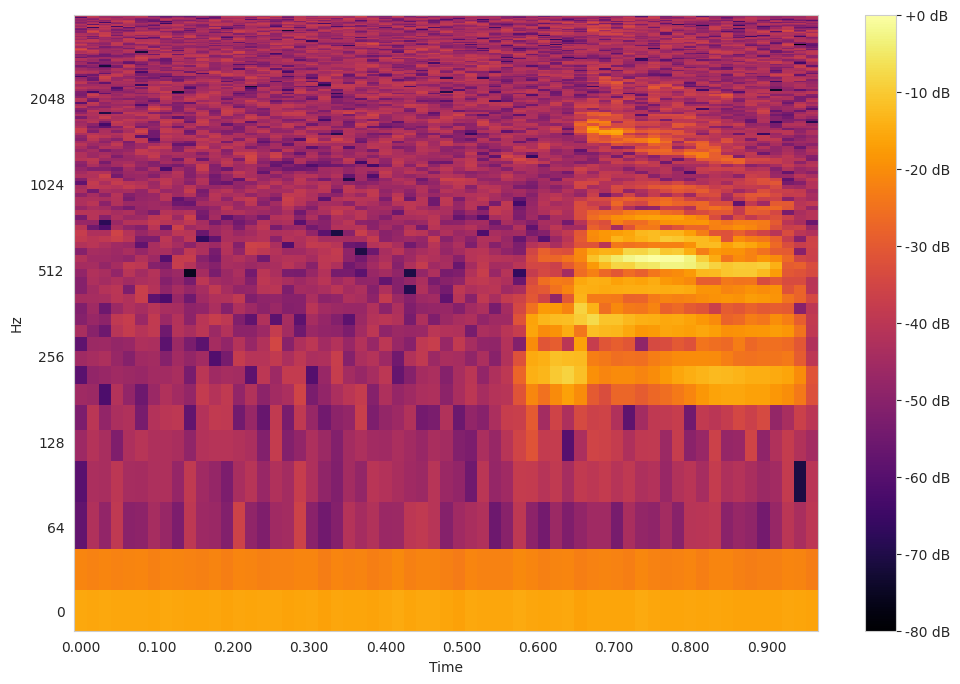

In [36]:
S_db = librosa.amplitude_to_db(np.abs(stft(data[90], fs=8e3, N=256, hop_size=128)[0]), ref=np.max)
# Plot the spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=8e3, cmap='inferno', hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

<BarContainer object of 8 artists>

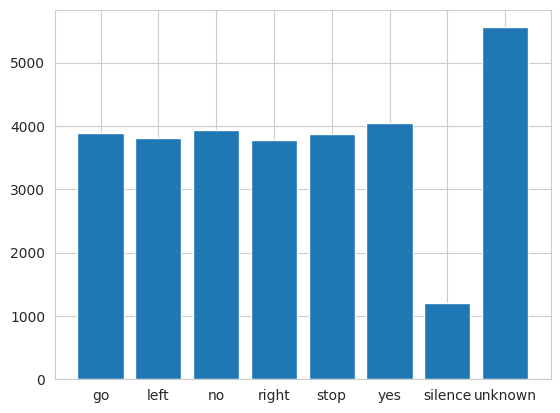

In [7]:
unique, counts = np.unique(labels, return_counts=True)

plt.bar(commands, counts)

# Split data into data and labels

In [88]:
TRAIN_PART = 0.7
VAL_PART = 0.1
TEST_PART = 0.2

train_data = data[:int(NEW_DATASET_LENGTH*TRAIN_PART)]
train_labels = labels[:int(NEW_DATASET_LENGTH*TRAIN_PART)]
TRAIN_LEN = len(train_data)

val_data = data[TRAIN_LEN:TRAIN_LEN+int(NEW_DATASET_LENGTH*VAL_PART)]
val_labels = labels[TRAIN_LEN:TRAIN_LEN+int(NEW_DATASET_LENGTH*VAL_PART)]
VAL_LEN = len(val_data)

test_data = data[TRAIN_LEN+VAL_LEN:]
test_labels = labels[TRAIN_LEN+VAL_LEN:]
TEST_LEN = len(test_data)

print(f"Train data length: {TRAIN_LEN}")
print(f"Validation data length: {VAL_LEN}")
print(f"Test data length: {TEST_LEN}")
print(f"Full dataset length: {NEW_DATASET_LENGTH}")

Train data length: 21045
Validation data length: 3006
Test data length: 6014
Full dataset length: 30065


# Normalize PCM audio vectors

In [89]:
print(f"[Train dataset] Max amplitude before normalization: {np.max(np.abs(train_data))}")
print(f"[Valid dataset] Max amplitude before normalization: {np.max(np.abs(val_data))}")
print(f"[Test dataset] Max amplitude before normalization: {np.max(np.abs(test_data))}")

train_data_max = np.max(np.abs(train_data))
valid_data_max = np.max(np.abs(val_data))
test_data_max = np.max(np.abs(test_data))

for i in range(len(train_data)):
    train_data[i] /= train_data_max
    print(i)

for i in range(len(val_data)):
    val_data[i] /= valid_data_max
    print(i)

for i in range(len(test_data)):
    test_data[i] /= test_data_max
    print(i)

print(f"[Train dataset] Max amplitude after normalization: {np.max(np.abs(train_data))}")
print(f"[Valid dataset] Max amplitude after normalization: {np.max(np.abs(val_data))}")
print(f"[Test dataset] Max amplitude after normalization: {np.max(np.abs(test_data))}")

train_data += np.random.normal(0, 0.01, train_data.shape)
val_data += np.random.normal(0, 0.01, val_data.shape)
test_data += np.random.normal(0, 0.01, test_data.shape)


[Train dataset] Max amplitude before normalization: 49288.7265625
[Valid dataset] Max amplitude before normalization: 45632.765625
[Test dataset] Max amplitude before normalization: 52985.34765625
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
2

In [90]:
display.Audio(val_data[6], rate=8000)

# Spectrograms

In [9]:
def get_spectrogram(pcm):
    D = librosa.stft(pcm, n_fft=256, hop_length=128, window='hann')
    return np.abs(D)

In [91]:
train_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in train_data])
valid_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in val_data])
test_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in test_data])

In [92]:
train_data = train_data.reshape(len(train_data), train_data[0].shape[0], train_data[0].shape[1], 1)
valid_data = valid_data.reshape(len(valid_data), valid_data[0].shape[0], valid_data[0].shape[1], 1)
test_data = test_data.reshape(len(test_data), test_data[0].shape[0], test_data[0].shape[1], 1)

# Model

In [102]:

# Update input shape
input_shape = train_data[0].shape  # This will now be (129, 126, 1)
print('Input shape:', input_shape)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(train_data)

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(16, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation='softmax'),
])

model.summary()

Input shape: (129, 61, 1)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_9 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_9 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 30, 30, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,899 (163.67 KB)

 Trainable params: 41,896 (163.66 KB)

 Non-trainable params: 3 (16.00 B)

In [103]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [104]:
train_labels = train_labels.astype(np.float32)
valid_labels = val_labels.astype(np.float32)

In [105]:
# logdir = tempfile.mkdtemp()
callbacks = [
  # tfmot.sparsity.keras.UpdatePruningStep(),
  # tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)
]

In [106]:
EPOCHS = 100
history = model.fit(train_data, train_labels,
    validation_data=(valid_data, valid_labels),
    epochs=EPOCHS,
    callbacks=callbacks,
    batch_size=256
)

Epoch 1/100
80/83 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1759 - loss: 2.0197

2025-01-17 13:52:58.431006: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[53,16,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[53,1,32,32]{3,2,1,0}, f32[16,1,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-17 13:52:58.461875: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[53,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[53,16,30,30]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1772 - loss: 2.0174

2025-01-17 13:53:00.920305: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[190,16,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[190,1,32,32]{3,2,1,0}, f32[16,1,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-17 13:53:00.984763: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[190,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[190,16,30,30]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.1777 - loss: 2.0166 - val_accuracy: 0.3200 - val_loss: 1.7794
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3165 - loss: 1.7553 - val_accuracy: 0.3925 - val_loss: 1.5936
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4142 - loss: 1.5674 - val_accuracy: 0.4910 - val_loss: 1.3534
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5026 - loss: 1.3436 - val_accuracy: 0.5579 - val_loss: 1.2054
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5432 - loss: 1.2085 - val_accuracy: 0.5858 - val_loss: 1.0985
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5846 - loss: 1.1145 - val_accuracy: 0.5935 - val_loss: 1.0617
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5946 - loss: 1.0670 - val_accuracy: 0.6364 - val_loss: 0.9849
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6199 - loss: 1.0168 - val_accuracy: 0.6507 - val_l

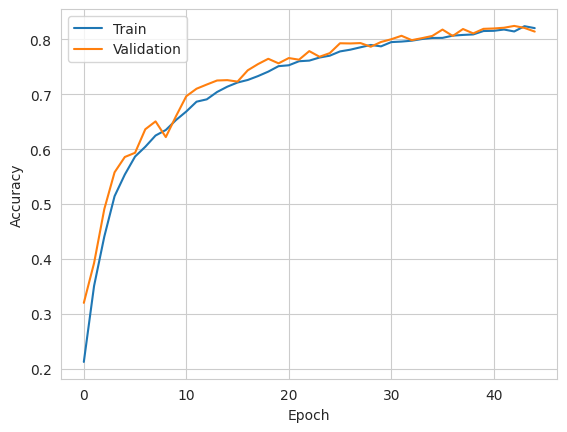

In [107]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

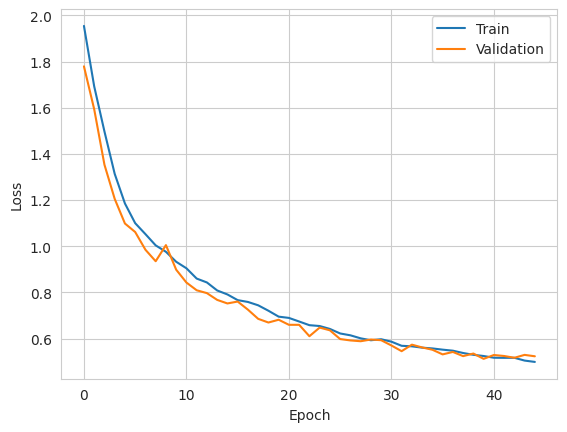

In [108]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
raw_test_data, raw_data_label = next(iter(dataset["test"].take(1)))

In [ ]:
display.Audio(raw_test_data.numpy(), rate=16000)

In [ ]:
# Add batch dimension to the first sample of test_data
sample = test_data[0]


img_array = tf.expand_dims(sample, 0)
print(img_array.shape)

prediction = np.argmax(model.predict(img_array), axis=1)
print(f"Prediction: {prediction}")

In [109]:
results = model.evaluate(test_data, test_labels, batch_size=128)
print("test loss, test acc:", results)

2025-01-17 13:53:50.328488: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[128,16,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,1,32,32]{3,2,1,0}, f32[16,1,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-17 13:53:50.389018: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[128,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,16,30,30]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

35/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8071 - loss: 0.5441

2025-01-17 13:53:51.057914: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[126,16,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[126,1,32,32]{3,2,1,0}, f32[16,1,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-17 13:53:51.098400: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[126,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[126,16,30,30]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8082 - loss: 0.5448
test loss, test acc: [0.544355034828186, 0.8106085658073425]


In [45]:
y_pred = np.argmax(model.predict(test_data), axis=1)

2025-01-16 20:01:03.772853: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,16,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,32,32]{3,2,1,0}, f32[16,1,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-16 20:01:03.829429: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,16,30,30]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-01-16 20:01:04.687659: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[31,16,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,1,32,32]{3,2,1,0}, f32[16,1,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-16 20:01:04.717903: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[31,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,16,30,30]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [22]:
import seaborn as sns

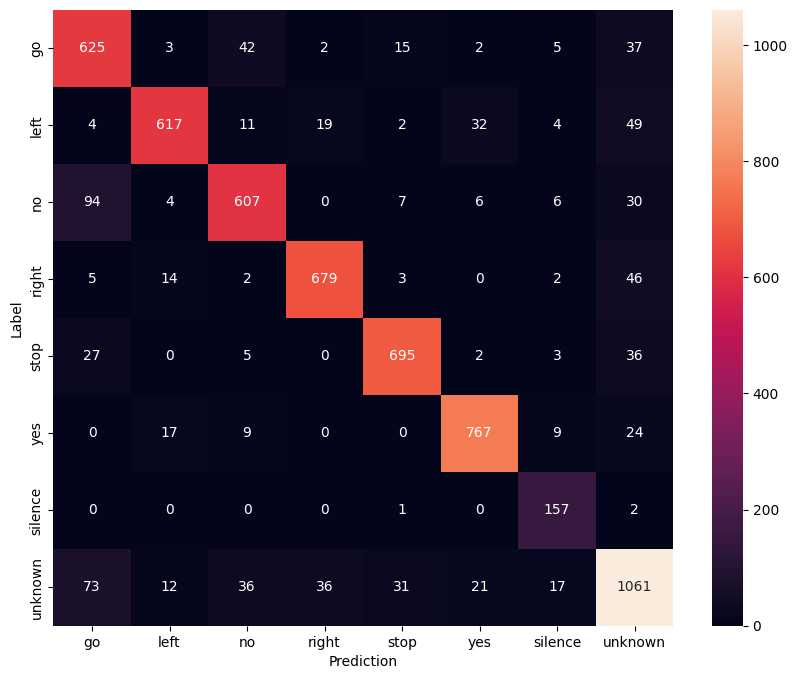

In [46]:
confusion_mtx = tf.math.confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [110]:
model.save("/home/vistek528/TRA_PROJ/NET_prototype/tra_medium_model_81_with_noise.keras")

# Fine-tuning

In [28]:
model = tf.keras.models.load_model("tra_medium_model_with_recursive_layer_86test_acc_8kHz_PioterSTFT.keras")

In [29]:
lr = 1e-5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [30]:
EPOCHS = 100
history = model.fit(train_data, train_labels,
    validation_data=(valid_data, valid_labels),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
    batch_size=1024
)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.8692 - loss: 0.3685 - val_accuracy: 0.8619 - val_loss: 0.3973
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8792 - loss: 0.3388 - val_accuracy: 0.8629 - val_loss: 0.3939
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8814 - loss: 0.3397 - val_accuracy: 0.8639 - val_loss: 0.3907
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8803 - loss: 0.3396 - val_accuracy: 0.8643 - val_loss: 0.3894
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8811 - loss: 0.3435 - val_accuracy: 0.8646 - val_loss: 0.3886
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8859 - loss: 0.3344 - val_accuracy: 0.8656 - val_loss: 0.3878
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8806 - loss: 0.3388 - val_accuracy: 0.8669 - val_loss: 0.3866
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8832 - loss: 0.3384 - val_accuracy: 0.

In [15]:
model = tf.keras.models.load_model("to_be_deployed/tra_medium_model_86test_acc_8kHz_PioterSTFT.keras")
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_5 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_5 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 30, 30, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 98, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,733 (581.00 KB)

 Trainable params: 49,576 (193.66 KB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 99,154 (387.32 KB)